<a href="https://www.kaggle.com/code/lakshmipriya190803/classifier-deepsmote-yolov8-inceptionv3-resnet?scriptVersionId=160161233" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Welcome :)

In this notebook I'm going to go through basics of Computer Vision needed for classification of images datset. This dataset requires multi-class classification, and there's a severe class imbalance, we will be tackling all of this in the upcoming sections.

In order to tackle the classification problem I'm going to use a technique called transfer learning,where knowledge gained from solving one problem is applied to a different but related problem. In the context of computer vision, it involves using pre-trained models, typically trained on large-scale datasets like ImageNet, as a starting point for solving new vision tasks.

Why transfer learning?

1. Reduced Training Time
2. Improved Performance
3. Effective Feature Extraction

Therefore I will be exploring the following models:



## 🚀YOLOv8 
YOLOv8 is a new state-of-the-art computer vision model built by Ultralytics, the creators of YOLOv5. The YOLOv8 model contains out-of-the-box support for object detection, classification, and segmentation tasks,and trains a model using the COCO dataset for 100 epochs. It includes simple functionality for Test Time Augmentation (TTA), model ensembling, hyperparameter evolution, and export to ONNX, CoreML and TFLite. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs. YOLOv8 detection models have no suffix and are the default YOLOv8 models, i.e. yolov8n.pt 

## 🚀InceptionV3
Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years. The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.

## 🚀ResNet
ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN). ResNet-50 is a 50-layer convolution neural network - 48 convolutional layers, 1 MaxPool layer, and 1 Average pool layer. ResNet is a type of Artificial Neural Network (ANN) that forms networks by stacking residual blocks.

* Very deep neural networks (plain network) are not practical to implement as they are hard to train due to vanishing gradients.
* The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
* There are two main types of ResNets blocks: The identity block and the convolutional block.
* Very deep Residual Networks are built by stacking these blocks together.

## 💡Inspiration:
I recently started to driving and in order to assist me in understanding the traffic rules and signs, I'm planning to create an app which built on top of this, in order to recognise and give a description of the sign I see on the road.  

## ❗Author's Note:

Make sure to run the cells from top to bottom with a GPU accelerator. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from sklearn.pipeline import Pipeline, make_pipeline

import torch
import torch.nn as nn
from sklearn.neighbors import NearestNeighbors

# Exploratory Data Analysis

In [2]:
#viewing the images in the training set

#loading pickled data 
#pickle is used for serializing and de-serializing a Python object structure. 
train_path = '/kaggle/input/german-traffic-sign-dataset/train.p'
test_path = '/kaggle/input/german-traffic-sign-dataset/test.p'
valid_path = '/kaggle/input/german-traffic-sign-dataset/valid.p'

label_path = '/kaggle/input/german-traffic-sign-dataset/signname.csv'


with open(train_path, mode = 'rb') as f:
    train = pickle.load(f)
    
with open(test_path, mode = 'rb') as f:
    test = pickle.load(f)
    
with open(valid_path, mode = 'rb') as f:
    valid = pickle.load(f)
    
sign_names = pd.read_csv(label_path)

In [3]:
type(test) , type(train) , type(valid)

(dict, dict, dict)

In [4]:
#getting column names for further processing
train_cols = list(train.keys())
test_cols = list(test.keys())
valid_cols = list(valid.keys())

print(f"Training colums : {train_cols}")
print(f"Testing columns : {test_cols}")
print(f"Validation columns : {valid_cols}")

Training colums : ['coords', 'labels', 'features', 'sizes']
Testing columns : ['sizes', 'coords', 'features', 'labels']
Validation columns : ['coords', 'labels', 'features', 'sizes']


In [5]:
#splitting the data into train, test and valid sets

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']
classes = np.unique(y_train)

print(f"Dimensions of one image : {X_train.shape[1:]}")
print(f"Number of training samples : {X_train.shape[0]}")
print(f"Number of testing samples : {X_test.shape[0]}")
print(f"Number of validation samples : {X_valid.shape[0]}")
print(f"Number of classes : {len(classes)}")
print(f"Does it contain null values? {np.unique(np.isnan(y_train))}")

Dimensions of one image : (32, 32, 3)
Number of training samples : 34799
Number of testing samples : 12630
Number of validation samples : 4410
Number of classes : 43
Does it contain null values? [False]


In [6]:
X_train_new = np.transpose(X_train, (0, 3, 1, 2))
X_train_new.shape

(34799, 3, 32, 32)

In [7]:
y_train[0]

41

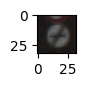

In [8]:
plt.figure(figsize=(0.5,0.5))
plt.imshow(X_train[0])
plt.show()

In [9]:
print(sign_names.head(5))
sign_names['SignName'][0]

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


'Speed limit (20km/h)'

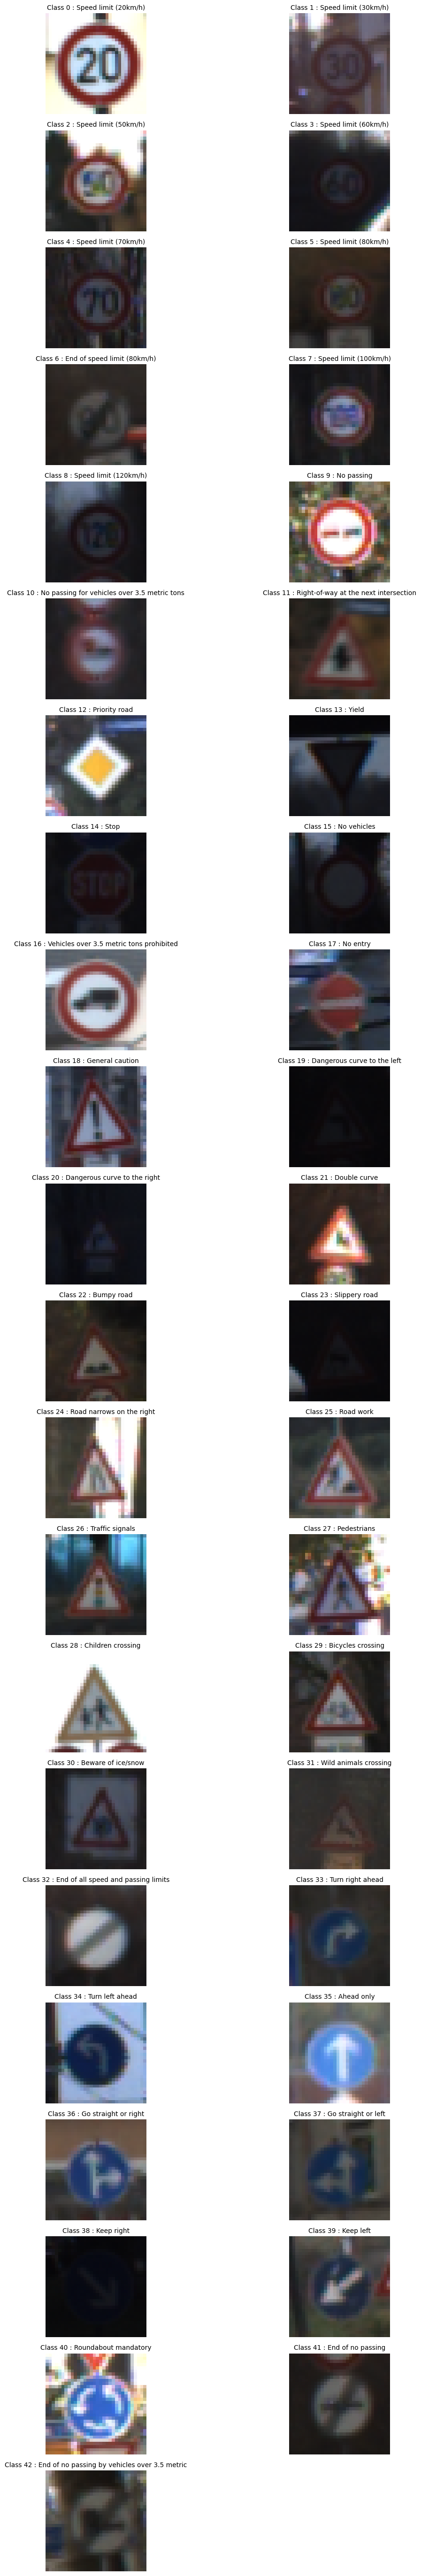

In [10]:
# Displaying sample image of each label
classes, class_start_index, class_total_count = np.unique(y_train, return_index=True, return_counts=True)

# Define the number of columns in each row
num_columns = 2

# Calculate the number of rows needed
num_rows = int(np.ceil(len(classes) / num_columns))

# Set the size of the images and labels
figsize = (12, 2.5 * num_rows)  # Adjust the height based on the number of rows
image_size = (0.5, 0.5)
label_font_size = 10

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)

# Add space between rows
fig.subplots_adjust(hspace=0.5)

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

for i, clas in enumerate(classes):
    #print(f"Class {clas} : {sign_names['SignName'][clas]}")
    ax = axes[i]
    
    # Calculate the index for the current class
    id = class_start_index[clas] + 5
    
    # Display the image with the specified size
    ax.imshow(X_train[id], aspect='equal', extent=(0, image_size[0], 0, image_size[1]))
    ax.set_title(f"Class {clas} : {sign_names['SignName'][clas]}", fontsize=label_font_size)
    ax.axis('off')

# Remove empty subplots
for j in range(len(classes), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

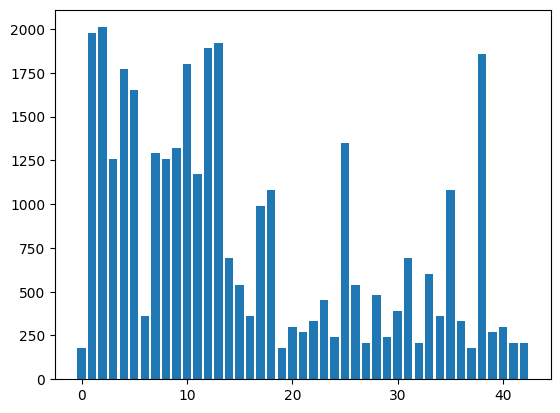

In [11]:
#class distribution of data of training dataset : 

plt.bar(classes, class_total_count)
plt.show()

In [12]:
print(f"Minimum number of images for some class : {min(class_total_count)}")
print(f"Maximum number of images for some class : {max(class_total_count)}")
print(f"Average number of images for some class : {int(sum(class_total_count) / len(class_total_count))}")

Minimum number of images for some class : 180
Maximum number of images for some class : 2010
Average number of images for some class : 809


### Conclusion : 

The class distribution is AWFUL, one class has 2000 training examples and another has just 180, so we must overcome this imbalance. Since the number of training examples overall is too low, I am going to do Oversampling and I'm going to implement a version of DeepSMOTE, using this paper and its code implementation as a reference: [deepSMOTE](https://ieeexplore.ieee.org/document/9694621)


"DeepSMOTE consists of an encoder/decoder framework, a SMOTE-based oversampling method, and a loss function with a reconstruction loss and a penalty term 

The encoder and decoder are trained in an end-to-end fashion. During DeepSMOTE training, an imbalanced dataset is fed to the encoder/decoder in batches. A reconstruction loss is computed on the batched data. All classes are used during training so that the encoder/decoder can learn to reconstruct both majority and minority class images from the imbalanced data. Because there are few minority class examples, majority class examples are used to train the model to learn the basic reconstruction patterns inherent in the data. This approach is based on the assumption that classes share some similar characteristics (e.g., all classes represent digits or faces)

" 

# DeepSMOTE

this is my first ever direct implementation of an algorithm from scratch after reading a paper and its code, i hope this is worth it!

High Level Overview:

1. Encoder
2. Decoder
3. Sampling using Nearest Neighbour

I will share as much explanation for everything I do as I go one, so bare with me guys!

In [13]:
#first ill create a list which would contain the number of samples needed to be generated for each class:
max_need = max(class_total_count)
samples_needed = []
for val in class_total_count:
    new_val = max_need - val
    samples_needed.append(new_val)
    
#samples_needed
    

I'm copying the Encoder Decoder Architecture implementation from here:

https://github.com/dd1github/DeepSMOTE/blob/main/GenerateSamples.py

if modifications are needed, i will perform them later on

In [14]:
##############################################################################
"""args for models"""

args = {}
args['dim_h'] = 32          # factor controlling size of hidden layers
args['n_channel'] = 32       # number of channels in the input data 

args['n_z'] = 300 #600     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 1 #50         # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True

Lets understand this particular line of code

> torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros', device = None, dtype = None)

in_channels are input channels 
out_channels are output channels


lets say in_channels = 3
and out_channels = 2 

what happens when we place kernel over a region of pixels in the image?
the pixel value imposed on the image by the kernel , both are multplied together, this is done for all pixels in the kernel-image region; all of it is added together in the end, a bias value may or may not be added

**kernel size** is filter size, **the larger the kernel is, the smaller the output matrix is**, it doesnt have to be a square matrix

**stride**
stride = 1 -> centre piece of the square kernel matrix moves one pixel by one pixel
stride = 2 -> central pixel of the square kernel matrix moves 2 pixels at a time; this reduces te output size; and its relevant to horizontal and vertical movement

**padding and padding mode**
to maintain the size of the input image whilst keeping the kernel size same, we can add padding to input sample
so something like this happens so that kernel has more space to move; padding_mode sets the value in the new pixels added 

**dilation**
spacing between the kernel_size
default is 1
if we change dilation = 2; upon applying the same kernel we get kernel imposition such that each kernel pixel placed over image pixel are one pixel apart 

it also reduces the shape of the output matrix


**groups**
for each group, there will be filters and we get one output for each group
so the number of group must be chosen such that the number of input channel is divisible by the number of output channel

**bias**
after applying the kernel, do we add the bias or not



In [15]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        # Extract relevant parameters from args dictionary
        self.n_channel = args['n_channel']  # Number of input channels
        self.dim_h = args['dim_h']          # Dimensionality of hidden layers
        self.n_z = args['n_z']              # Dimensionality of the latent space
        
        # Define the convolutional layers for feature extraction
        self.conv = nn.Sequential(
            #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros', device = None, dtype = None)
            #in_channels are input channels; for a colour image we will have 3 channels, 
            
            nn.Conv2d(self.n_channel, self.dim_h, 3, 1, 1, bias=False),  # 1st convolutional layer
            nn.LeakyReLU(0.2, inplace=True),                              # Leaky ReLU activation
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),  # 2nd convolutional layer
            nn.BatchNorm2d(self.dim_h * 2),                               # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),                              # Leaky ReLU activation
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),  # 3rd convolutional layer
            nn.BatchNorm2d(self.dim_h * 4),                               # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),                              # Leaky ReLU activation
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),  # 4th convolutional layer
            nn.BatchNorm2d(self.dim_h * 8),                               # Batch normalization
            nn.LeakyReLU(0.2, inplace=True)                               # Leaky ReLU activation
        )
        
        # Define the fully connected layer for dimensionality reduction to the latent space
        self.fc = nn.Linear(self.dim_h * 8 * 4 * 4, self.n_z)

    def forward(self, x):
        # Forward pass through the encoder
        x = x.permute(0, 3, 1, 2)
        x = self.conv(x)            # Apply convolutional layers
        x = x.view(x.size(0), -1)   # Flatten the output
        x = self.fc(x)              # Apply the fully connected layer for dimensionality reduction
        return x

In [16]:
## Decoder model definition
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        # Extract relevant parameters from args dictionary
        self.n_channel = args['n_channel']  # Number of input channels
        self.dim_h = args['dim_h']          # Dimensionality of hidden layers
        self.n_z = args['n_z']              # Dimensionality of the latent space

        # Define the fully connected layer for initial up-sampling
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),  # Fully connected layer
            nn.ReLU()                                     # ReLU activation
        )

        # Define the deconvolutional layers for generating the output image
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),  # 1st deconvolutional layer
            nn.BatchNorm2d(self.dim_h * 4),                          # Batch normalization
            nn.ReLU(True),                                           # ReLU activation
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),   # 2nd deconvolutional layer
            nn.BatchNorm2d(self.dim_h * 2),                          # Batch normalization
            nn.ReLU(True),                                           # ReLU activation
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),      # 3rd deconvolutional layer
            #nn.Sigmoid()                                            # Sigmoid activation (commented out)
            nn.Tanh()                                               # Tanh activation
        )

    def forward(self, x):
        # Forward pass through the decoder
        x = self.fc(x)                              # Apply the fully connected layer for up-sampling
        x = x.view(-1, self.dim_h * 8, 7, 7)        # Reshape to the desired feature map shape
        x = self.deconv(x)                          # Apply deconvolutional layers for image generation

In [17]:
#now we need to get a batch of samples from each class so that we can generate dataset from that subset; 

#im going to keep that subset at 180 since that is the minimum number of images available:

def create_sample_batch(class_number):
    start_index = class_start_index[class_number]
    end_index = class_start_index[class_number] + 180
    X_sample_train = X_train_new[start_index : end_index]
    y_sample_train = y_train[start_index : end_index]
    return X_sample_train, y_sample_train
    
    
'''
for i in range(0,43):
    x_train_class, y_train_class = create
'''
x_train_class, y_train_class = create_sample_batch(0)
x_train_class.shape , y_train_class.shape

((180, 3, 32, 32), (180,))

In [18]:
'''
train_on_gpu = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(args)
#encoder.load_state_dict(torch.lo)
encoder = encoder.to(device)

decoder = Decoder(args)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()
for class_number in range(0,43):
    
    x_train_class, y_train_class = create_sample_batch(class_number)
    #encode training samples to feature space
    x_train_class = torch.Tensor(x_train_class)
    x_train_class = x_train_class.to(device)
    x_train_class = encoder(x_train_class)
    print(f"x_train_class.shape{x_train_class.shape}")
    
    x_train_class = x_train_class.detach().cpu().numpy()
 '''   
    
    

    
    

'\ntrain_on_gpu = torch.cuda.is_available()\ndevice = \'cuda\' if torch.cuda.is_available() else \'cpu\'\n\nencoder = Encoder(args)\n#encoder.load_state_dict(torch.lo)\nencoder = encoder.to(device)\n\ndecoder = Decoder(args)\ndecoder = decoder.to(device)\n\nencoder.eval()\ndecoder.eval()\nfor class_number in range(0,43):\n    \n    x_train_class, y_train_class = create_sample_batch(class_number)\n    #encode training samples to feature space\n    x_train_class = torch.Tensor(x_train_class)\n    x_train_class = x_train_class.to(device)\n    x_train_class = encoder(x_train_class)\n    print(f"x_train_class.shape{x_train_class.shape}")\n    \n    x_train_class = x_train_class.detach().cpu().numpy()\n '